In [1]:
import sys

import pandas as pd
import numpy as np
import math

import icesat2

In [2]:
# Configure Session #
icesat2.init("http://44.227.4.67:9081", True)
resource = "_20181017222812_02950102_003_01.h5"
region = [ {"lon": -108.3435200747503, "lat": 38.89102961045247},
           {"lon": -107.7677425431139, "lat": 38.90611184543033}, 
           {"lon": -107.7818591266989, "lat": 39.26613714985466},
           {"lon": -108.3605610678553, "lat": 39.25086131372244},
           {"lon": -108.3435200747503, "lat": 38.89102961045247} ]

In [3]:
#
# Distance between two coordinates
#
def geodist(lat1, lon1, lat2, lon2):

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    dist = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    dist = 2.0 * math.atan2(math.sqrt(dist), math.sqrt(1.0 - dist))
    dist = 6373.0 * dist

    return dist

In [4]:
#
# SlideRule Processing Request
#
def algoexec(resource):

    # Build ATL06 Request
    parms = {
#        "poly": region
        "srt": icesat2.SRT_LAND,
        "cnf": icesat2.CNF_SURFACE_HIGH,
        "ats": 10.0,
        "cnt": 10,
        "len": 40.0,
        "res": 20.0,
        "maxi": 1
    }

    # Request ATL06 Data
    rsps = icesat2.atl06(parms, resource, as_numpy=False)

    # Calculate Distances
    lat_origin = rsps["lat"][0]
    lon_origin = rsps["lon"][0]
    distances = [geodist(lat_origin, lon_origin, rsps["lat"][i], rsps["lon"][i]) for i in range(len(rsps["h_mean"]))]

    # Build Dataframe of SlideRule Responses
    df = pd.DataFrame(data=list(zip(rsps["h_mean"], distances, rsps["lat"], rsps["lon"], rsps["spot"])), index=rsps["segment_id"], columns=["h_mean", "distance", "latitude", "longitude", "spot"])

    # Return DataFrame
    print("Reference Ground Tracks: {} to {}".format(min(rsps["rgt"]), max(rsps["rgt"])))
    print("Cycle: {} to {}".format(min(rsps["cycle"]), max(rsps["cycle"])))
    print("Retrieved {} points from SlideRule".format(len(rsps["h_mean"])))
    return df

In [5]:
# Execute SlideRule Algorithm
act = algoexec("ATL03"+resource)

atl06 processing initiated on ATL03_20181017222812_02950102_003_01.h5 ...
... continuing to read ATL03_20181017222812_02950102_003_01.h5 (after 10 seconds)
... continuing to read ATL03_20181017222812_02950102_003_01.h5 (after 20 seconds)
... continuing to read ATL03_20181017222812_02950102_003_01.h5 (after 30 seconds)
... continuing to read ATL03_20181017222812_02950102_003_01.h5 (after 40 seconds)
... continuing to read ATL03_20181017222812_02950102_003_01.h5 (after 50 seconds)
... continuing to read ATL03_20181017222812_02950102_003_01.h5 (after 60 seconds)


Reference Ground Tracks: 295 to 295
Cycle: 1 to 1
Retrieved 458884 points from SlideRule


In [6]:
# Build Track (Actual) Datasets
track1 = act[act["spot"].isin([1, 2])].sort_values(by=['distance'])
track2 = act[act["spot"].isin([3, 4])].sort_values(by=['distance'])
track3 = act[act["spot"].isin([5, 6])].sort_values(by=['distance'])

In [7]:
# Import MatPlotLib Package
import matplotlib.pyplot as plt

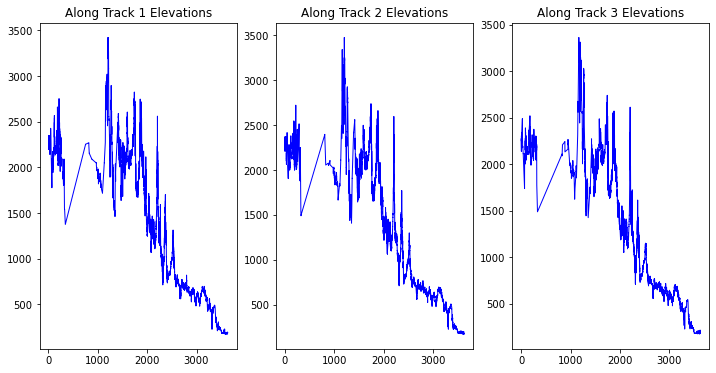

In [8]:
# Create Elevation Plot
fig = plt.figure(num=None, figsize=(12, 6))

# Plot Track 1 Elevations
ax1 = plt.subplot(131)
ax1.set_title("Along Track 1 Elevations")
ax1.plot(track1["distance"].values, track1["h_mean"].values, linewidth=1.0, color='b')

# Plot Track 2 Elevations
ax2 = plt.subplot(132)
ax2.set_title("Along Track 2 Elevations")
ax2.plot(track2["distance"].values, track2["h_mean"].values, linewidth=1.0, color='b')

# Plot Track 3 Elevations
ax3 = plt.subplot(133)
ax3.set_title("Along Track 3 Elevations")
ax3.plot(track3["distance"].values, track3["h_mean"].values, linewidth=1.0, color='b')

# Show Plot
plt.show()

In [9]:
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

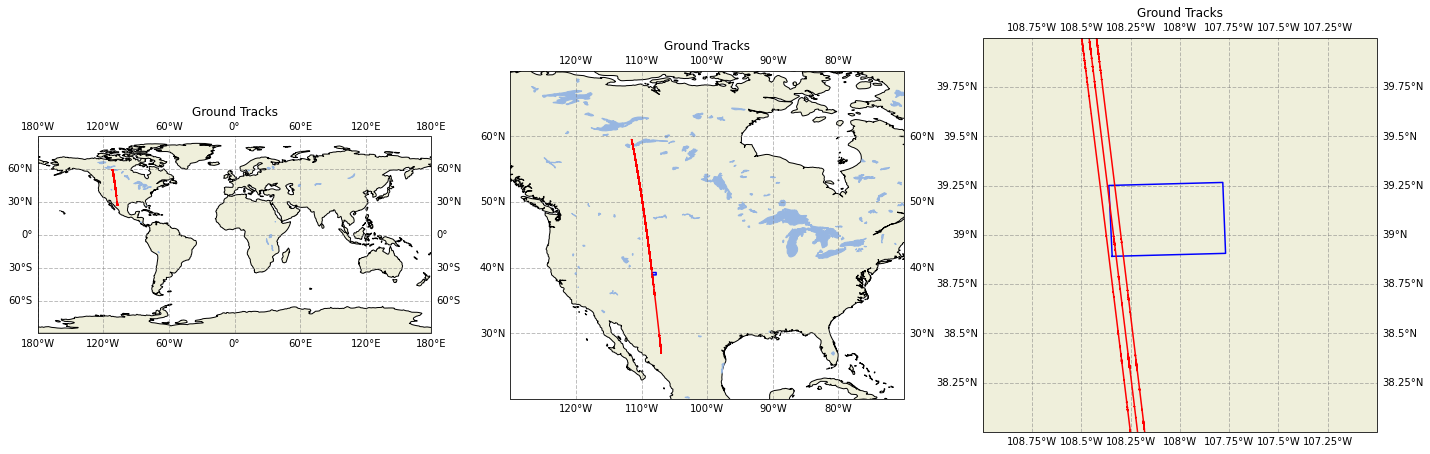

In [10]:
# Create PlateCarree Plot
fig = plt.figure(num=None, figsize=(24, 12))

################################
# add global plot
################################
ax1 = plt.subplot(131,projection=cartopy.crs.PlateCarree())
ax1.set_title("Ground Tracks")

# add coastlines with filled land and lakes
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES)
ax1.set_extent((-180,180,-90,90),crs=cartopy.crs.PlateCarree())

# format grid lines
gl = ax1.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])

# plot ground tracks
ax1.plot(track1["longitude"], track1["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())
#ax1.plot(track2["longitude"], track2["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())
#ax1.plot(track3["longitude"], track3["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())

################################
# add mid-zoom plot
################################
ax2 = plt.subplot(132,projection=cartopy.crs.PlateCarree())
ax2.set_title("Ground Tracks")

# add coastlines with filled land and lakes
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES)
ax2.set_extent((-130,-70,20,70),crs=cartopy.crs.PlateCarree())

# Plot Bounding Box
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]
ax2.plot(box_lon, box_lat, linewidth=1.5, color='b', zorder=2, transform=cartopy.crs.Geodetic())

# format grid lines
gl = ax2.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plot ground tracks
ax2.plot(track1["longitude"], track1["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())
#ax2.plot(track2["longitude"], track2["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())
#ax2.plot(track3["longitude"], track3["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())

################################
# add mid-zoom plot
################################
ax3 = plt.subplot(133,projection=cartopy.crs.PlateCarree())
ax3.set_title("Ground Tracks")

# add coastlines with filled land and lakes
ax3.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES)
ax3.set_extent((-109,-107,38,40),crs=cartopy.crs.PlateCarree())

# Plot Bounding Box
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]
ax3.plot(box_lon, box_lat, linewidth=1.5, color='b', zorder=2, transform=cartopy.crs.Geodetic())

# format grid lines
gl = ax3.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plot ground tracks
ax3.plot(track1["longitude"], track1["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())
ax3.plot(track2["longitude"], track2["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())
ax3.plot(track3["longitude"], track3["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())

# show plot
plt.show()